## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


captions.txt  images  test_captions.txt  train_captions.txt  val_captions.txt
There are 50 image to captions


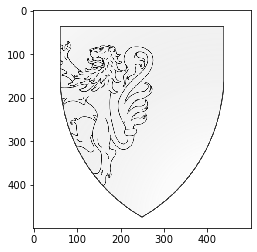

Caption: image_12.png
Caption: image_13.png
Caption: image_14.png
Caption: image_15.png
Caption: image_16.png


In [25]:
#location of the data 
data_location =  '/home/space/datasets/COA/generated-data-api-smaller'
# data_location =  'generated-data-api'
!ls $data_location

#reading the text data 

caption_file = data_location + '/captions.txt'
root_folder_images = data_location + '/images'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)



#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

image_path = data_location + '/images/'+ df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:", df.iloc[i,0])


# Split Data into Training/Test datasets 

In [26]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, validate, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_captions.txt'
val_annotation_file  = data_location + '/val_captions.txt'
test_annotation_file  = data_location + '/test_captions.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


In [27]:
#imports 
import os
import torch
import spacy
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from datetime import datetime
from tqdm import tqdm
from time import sleep


from src.baseline.vocabulary import Vocabulary
from src.baseline.coa_dataset import CoADataset
from src.baseline.caps_collate import CapsCollate
from src.baseline.data_loader import get_loader

# torch.cuda.empty_cache()


In [28]:
!export CUDA_VISIBLE_DEVICES=0

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
torch.cuda.get_device_name(0)

'NVIDIA TITAN RTX'

# Image Captioning With Attention - Pytorch

In [31]:
#show the tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

def print_time(text):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("{} @ Time = {}".format(text, current_time))


In [32]:
#Initiate the Dataset and Dataloader

#setting the constants
# BATCH_SIZE = 256
BATCH_SIZE = 5
NUM_WORKER = 2
freq_threshold = 5
# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'g': 4, 'v': 5, 'b': 6, 'cross': 7, 'lion': 8, 'passt': 9, 's': 10, 'a': 11, 'eagle': 12, 'o': 13, 'doubleheaded': 14, "'s": 15, 'head': 16, 'patonce': 17, 'moline': 18, 'guard': 19, 'rampant': 20}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'g', 5: 'v', 6: 'b', 7: 'cross', 8: 'lion', 9: 'passt', 10: 's', 11: 'a', 12: 'eagle', 13: 'o', 14: 'doubleheaded', 15: "'s", 16: 'head', 17: 'patonce', 18: 'moline', 19: 'guard', 20: 'rampant'}
        
#defining the transform to be applied

transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

print_time('writing the dataloader')

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loader(
    root_folder=root_folder_images,
    train_annotation_file=train_annotation_file,
    val_annotation_file=val_annotation_file,
    test_annotation_file=test_annotation_file,
    transform=transform,
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE
)

print_time('finished writing the dataloader')

# batch size = 10 
# writing the dataloader @ Time = 17:11:37
# finished writing the dataloader @ Time = 17:42:28


# batch size = 1024 & no build-vocab = no time at all



writing the dataloader @ Time = 11:12:38
vocab is passed
vocab is passed
vocab is passed
finished writing the dataloader @ Time = 11:12:38


In [33]:
len(train_loader), len(val_loader), len(test_loader), len(train_dataset), len(val_dataset), len(test_dataset)

(6, 2, 2, 30, 10, 10)

In [34]:
train_dataset.vocab.stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 'g': 4,
 'v': 5,
 'b': 6,
 'cross': 7,
 'lion': 8,
 'passt': 9,
 's': 10,
 'a': 11,
 'eagle': 12,
 'o': 13,
 'doubleheaded': 14,
 "'s": 15,
 'head': 16,
 'patonce': 17,
 'moline': 18,
 'guard': 19,
 'rampant': 20}

In [35]:
train_dataset.vocab.itos

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: '<UNK>',
 4: 'g',
 5: 'v',
 6: 'b',
 7: 'cross',
 8: 'lion',
 9: 'passt',
 10: 's',
 11: 'a',
 12: 'eagle',
 13: 'o',
 14: 'doubleheaded',
 15: "'s",
 16: 'head',
 17: 'patonce',
 18: 'moline',
 19: 'guard',
 20: 'rampant'}

# Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

https://blog.floydhub.com/attention-mechanism/

https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
    

In [36]:
import torch
import nltk
import numpy as np
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
from src.baseline.model import EncoderCNN, Attention, DecoderRNN, EncoderDecoder


In [37]:
#helper function to save the model
def save_model(model, optimizer, epoch, model_full_path):
    model_state = {
        'epoch': epoch,
        'embed_size': embed_size,
        'vocab_size': len(train_dataset.vocab),
        'attention_dim': attention_dim,
        'encoder_dim': encoder_dim,
        'decoder_dim': decoder_dim,
        'state_dict': model.state_dict(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    torch.save(model_state, model_full_path)
    

def get_new_model():
    model = EncoderDecoder(embed_size, len(train_dataset.vocab), attention_dim, encoder_dim, decoder_dim, drop_prob=0.3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])

    return model, optimizer, criterion


def load_model(model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model, _, _ = get_new_model()
    
    model.load_state_dict(torch.load(model_path))

    return model

def load_model_checkpoint(model_path):
    checkpoint = torch.load(model_path)
    
    model, optimizer, criterion = get_new_model()
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, epoch, loss



### Setting Hypperparameter and Init the model

In [38]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [39]:
# model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
# model = load_trained_model(model_path)

In [40]:
#initialize new model, loss etc
model, optimizer, criterion = get_new_model()

## Training Job from above configs

In [41]:
# model_full_path = '/home/space/datasets/COA/models/baseline/attention_model_state-smalll-mon.pth'
# model, optimizer, epoch, loss = load_model_checkpoint(model_full_path)


## Caption Translator Class

In [42]:
from src.label_checker_automata import LabelCheckerAutomata
from src.armoria_api import ArmoriaAPIPayload

class Caption:

    # (e.g. "A lion rampant")
    def __init__(self, label): 
        self.label = label

    # (e.g. “com")
    def get_automata_parsed(self, support_plural=False): 
        simple_automata = LabelCheckerAutomata(support_plural=support_plural)
        return simple_automata.parse_label(label)

    # ({“Colors”:[‘A’], “Object/Modifier”: [“lion rampant”]})
    def get_aligned(self, support_plural=False):
        simple_automata = LabelCheckerAutomata(support_plural=support_plural)
        parsed_label = simple_automata.parse_label(self.label)
        return simple_automata.align_parsed_label(self.label, parsed_label)

    def get_armoria_payload_dict(self):
        return ArmoriaAPIPayload(self.label.split()).get_armoria_payload()

    # (['A', 'lion rampant’])
    def get_tokenized(self):
        pass

    #  [1,3,2,4,2]
    def get_numericalized():
        pass
    
l = 'b g lion passt'
c = Caption(l).get_aligned() 
print(c)

l = 'b g lion lion'
c = Caption(l).get_aligned() 
print(c)

l = 'b a lion passt guard'
c = Caption(l).get_aligned() 
print(c)

{'colors': ['b', 'g'], 'objects': ['lion'], 'modifiers': ['passt'], 'numbers': [], 'positions': []}
{'colors': ['b', 'g'], 'objects': ['lion', 'lion'], 'modifiers': [], 'numbers': [], 'positions': []}
{'colors': ['b', 'a'], 'objects': ['lion'], 'modifiers': ['passt', 'guard'], 'numbers': [], 'positions': []}


## Calculate Accuracy

In [52]:
class Accuracy:
    def __init__(self, predicted, correct, weights_map={'shield_color': 10, 'charge_color': 10, 'charge': 60, 'modifier': 10}):
        self.predicted = predicted
        self.correct = correct
        self.weights_map= weights_map
        self.total_colors = 6 # from armoria_api.py
        self.total_charges = 3 # from armoria_api.py
        self.total_mods = 9 # counted from armoria_api.py ### maybe fix each ch with mod ==> count them together in next iteration
    
    def get(self):
        predicted_cap = Caption(self.predicted).get_aligned()
        correct_cap = Caption(self.correct).get_aligned()
        
        acc_sh_colors=0
        acc_ch_colors=0
        acc_charge=0
        acc_mod=0
        acc = 0

        ## TODO fix the align_parsed_label() function to return shield color and charges colors
        try:
            if predicted_cap['colors'][0] == correct_cap['colors'][0]:
                acc_sh_colors+= 1
            if predicted_cap['colors'][1] == correct_cap['colors'][1]:
                acc_ch_colors+= 1
        except:
            print('error in accessing key of predicted_cap',len(predicted_cap['colors']))

        for co in correct_cap['objects']:
            for po in predicted_cap['objects']:
                if co == po:
                    acc_charge+= 1
                    break
                    

        for cm in correct_cap['modifiers']:
            for pm in predicted_cap['modifiers']:
                if cm == pm:
                    acc_mod+= 1
                    break
        
        acc = acc_sh_colors * self.weights_map['shield_color'] + \
              acc_ch_colors * self.weights_map['charge_color'] + \
              acc_charge * self.weights_map['charge'] + \
              acc_mod * self.weights_map['modifier']

        return acc

    def get_charge_acc():
        pass
    
    def get_charge_color_acc():
        pass
    
    def get_charge_shield_acc():
        pass

c = Accuracy( 'b a lion lion', 'b a lion passt guard',).get()
print(c)

c = Accuracy('b a lion passt guard', 'b a lion passt guard', ).get()
print(c)

c = Accuracy('b a eagle', 'b a lion passt guard').get()
print(c)

c = Accuracy('A O lion rampant', 'A G lion rampant').get()
print(c)

80
100
20
80


In [53]:
# Function to test the model with the val dataset and print the accuracy for the test images
def validate(model):
    accuracy = 0
    total = len(val_loader)
    bleu_score = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for idx, (img, correct_cap) in enumerate(iter(val_loader)):
            features = model.encoder(img.to(device))

            features_tensors = img[0].detach().clone().unsqueeze(0)
            features = model.encoder(features_tensors.to(device))

            caps,_ = model.decoder.generate_caption(features,vocab=val_dataset.vocab)   
            caps = caps[:-1]
            predicted_caption = ' '.join(caps)

            correct_caption = []
            for j in correct_cap.T[0]:
                if j.item() not in [0, 1, 2 , 3]:
                    correct_caption.append(val_dataset.vocab.itos[j.item()])
            correct_caption_s = ' '.join(correct_caption)

            print('correct_caption: ', correct_caption_s)
            print('predicted_caption: ', predicted_caption)
            
            show_image(img[0], title=predicted_caption)
                        
            accuracy += Accuracy(predicted_caption,correct_caption_s).get()
            
            bleu = nltk.translate.bleu_score.sentence_bleu([correct_caption], caps, weights=(0.5, 0.5))
            
            bleu_score += bleu
            
    # compute the accuracy over all test images
    acc_score = (100 * accuracy / total)
    return bleu_score, acc_score



In [54]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

cuda


Epoch 1:   0%|                                                         | 0/6 [00:01<?, ?batch/s, loss=2.27]

correct_caption:  a o lion passt guard
predicted_caption:  b lion lion


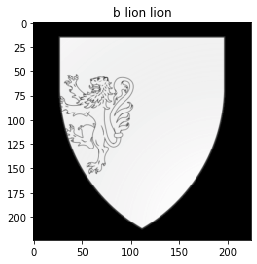

error in accessing key of predicted_cap 1
correct_caption:  a o lion 's head
predicted_caption:  b lion lion


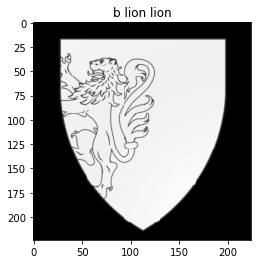

error in accessing key of predicted_cap 1


Epoch 1:  17%|████████▏                                        | 1/6 [00:05<00:26,  5.40s/batch, loss=2.03]

correct_caption:  a o lion rampant
predicted_caption:  a lion lion


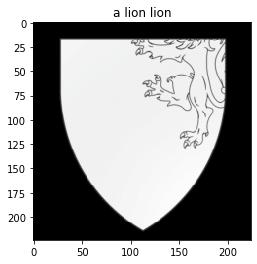

error in accessing key of predicted_cap 1
correct_caption:  b s lion rampant
predicted_caption:  a lion lion


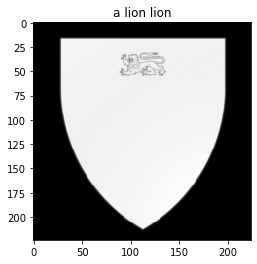

error in accessing key of predicted_cap 1


Epoch 1:  33%|████████████████▎                                | 2/6 [00:08<00:15,  3.75s/batch, loss=1.83]

correct_caption:  a g lion passt guard
predicted_caption:  a lion lion passt


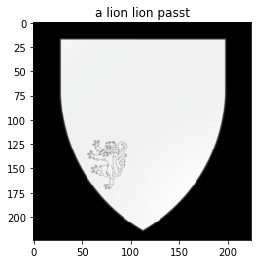

error in accessing key of predicted_cap 1
correct_caption:  a o lion rampant
predicted_caption:  a lion lion


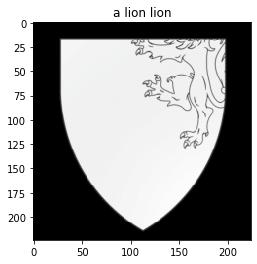

Epoch 1:  50%|████████████████████████▌                        | 3/6 [00:10<00:09,  3.17s/batch, loss=1.81]

error in accessing key of predicted_cap 1
correct_caption:  b s lion rampant
predicted_caption:  a a lion lion


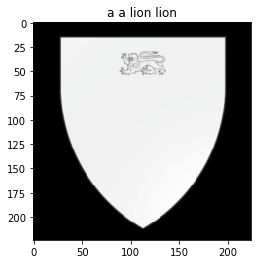

correct_caption:  a o lion passt guard
predicted_caption:  a lion lion passt


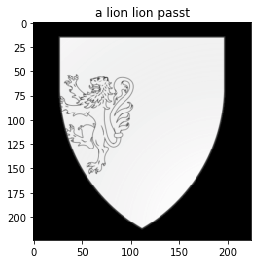

error in accessing key of predicted_cap 1


Epoch 1:  67%|████████████████████████████████▋                | 4/6 [00:12<00:05,  2.76s/batch, loss=1.86]

correct_caption:  a v lion passt guard
predicted_caption:  a lion passt


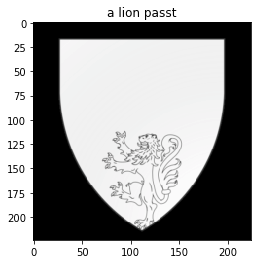

error in accessing key of predicted_cap 1
correct_caption:  a o lion rampant
predicted_caption:  a a lion lion passt


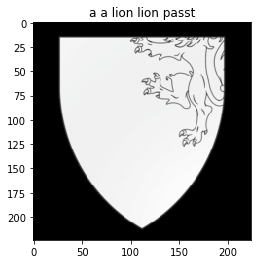

Epoch 1:  83%|████████████████████████████████████████▊        | 5/6 [00:14<00:02,  2.54s/batch, loss=1.66]

correct_caption:  a g lion passt guard
predicted_caption:  a a lion passt


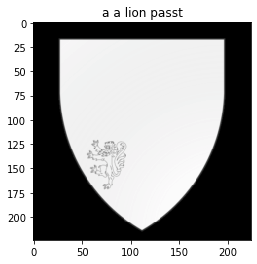

correct_caption:  b v lion 's head
predicted_caption:  a lion passt


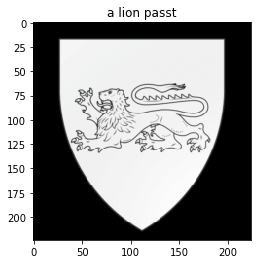

error in accessing key of predicted_cap 1


Epoch 2:   0%|                                                         | 0/6 [00:01<?, ?batch/s, loss=1.64]

correct_caption:  a v lion passt guard
predicted_caption:  b a lion passt


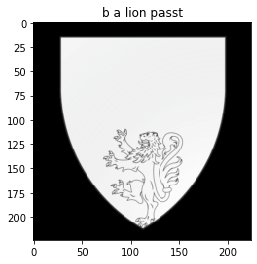

correct_caption:  a o lion rampant
predicted_caption:  b a lion passt


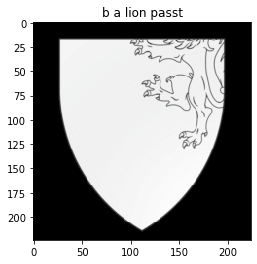

Epoch 2:  17%|████████▏                                        | 1/6 [00:05<00:26,  5.24s/batch, loss=1.48]

correct_caption:  a v lion rampant
predicted_caption:  b lion passt


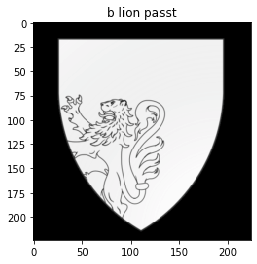

error in accessing key of predicted_cap 1
correct_caption:  b g lion passt
predicted_caption:  b b lion passt


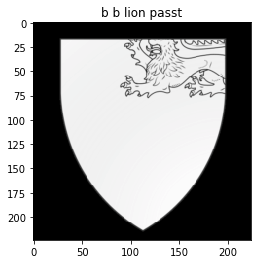

Epoch 2:  33%|████████████████▎                                | 2/6 [00:07<00:14,  3.75s/batch, loss=1.57]

correct_caption:  a v lion rampant
predicted_caption:  b lion passt


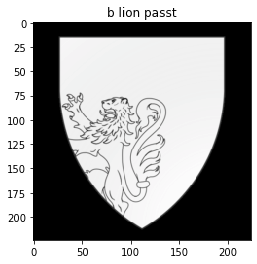

error in accessing key of predicted_cap 1
correct_caption:  a o lion passt guard
predicted_caption:  b lion passt


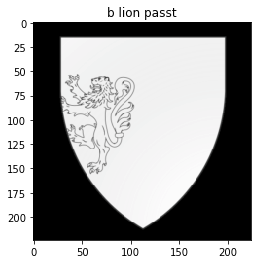

error in accessing key of predicted_cap 1


Epoch 2:  50%|████████████████████████▌                        | 3/6 [00:10<00:09,  3.01s/batch, loss=1.37]

correct_caption:  a v lion passt guard
predicted_caption:  b lion passt


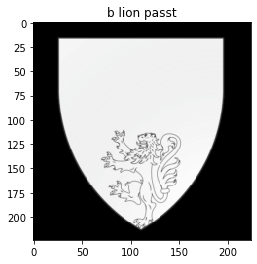

error in accessing key of predicted_cap 1
correct_caption:  b s lion rampant
predicted_caption:  b lion passt


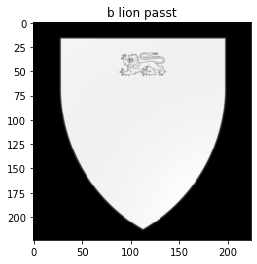

error in accessing key of predicted_cap 1


Epoch 2:  67%|████████████████████████████████▋                | 4/6 [00:12<00:05,  2.66s/batch, loss=1.52]

correct_caption:  a g lion passt guard
predicted_caption:  b lion passt


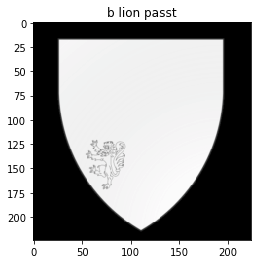

error in accessing key of predicted_cap 1
correct_caption:  a g lion 's head
predicted_caption:  b lion passt


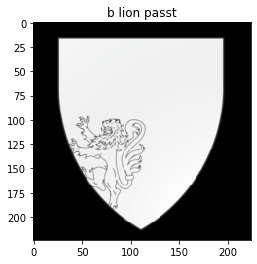

error in accessing key of predicted_cap 1


Epoch 2:  83%|████████████████████████████████████████▊        | 5/6 [00:14<00:02,  2.46s/batch, loss=1.38]

correct_caption:  a g lion passt guard
predicted_caption:  b lion passt


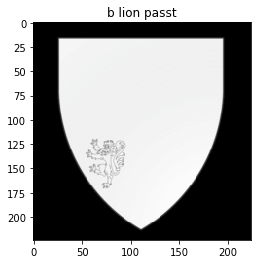

error in accessing key of predicted_cap 1
correct_caption:  b g lion passt
predicted_caption:  b lion lion passt


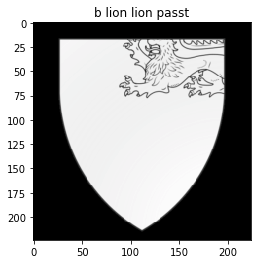

error in accessing key of predicted_cap 1


Epoch 3:   0%|                                                         | 0/6 [00:01<?, ?batch/s, loss=1.28]

correct_caption:  a g lion 's head
predicted_caption:  b lion passt


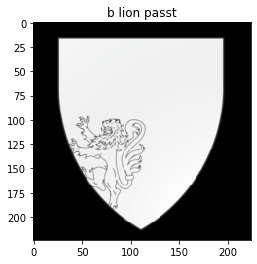

error in accessing key of predicted_cap 1
correct_caption:  b s lion rampant
predicted_caption:  b lion passt


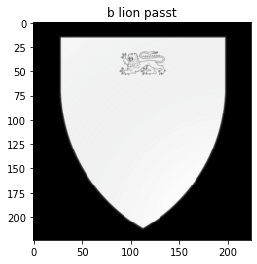

Epoch 3:  17%|████████▏                                        | 1/6 [00:05<00:26,  5.39s/batch, loss=1.18]

error in accessing key of predicted_cap 1
correct_caption:  b s lion rampant
predicted_caption:  b lion passt


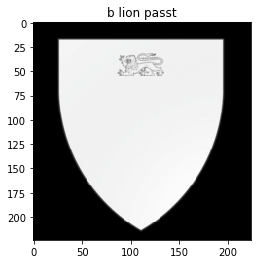

error in accessing key of predicted_cap 1
correct_caption:  b v lion 's head
predicted_caption:  a lion passt


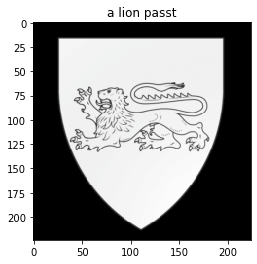

Epoch 3:  33%|████████████████▎                                | 2/6 [00:08<00:15,  3.93s/batch, loss=1.35]

error in accessing key of predicted_cap 1
correct_caption:  b g lion passt
predicted_caption:  a lion passt


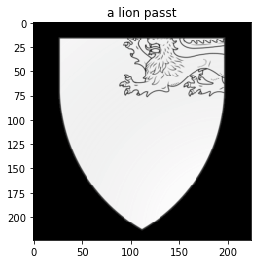

error in accessing key of predicted_cap 1
correct_caption:  a g lion passt guard
predicted_caption:  a lion passt


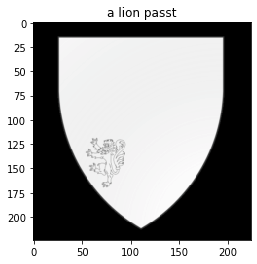

error in accessing key of predicted_cap 1


Epoch 3:  50%|████████████████████████▌                        | 3/6 [00:10<00:09,  3.14s/batch, loss=1.24]

correct_caption:  b s lion rampant
predicted_caption:  a lion passt


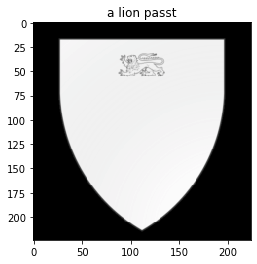

error in accessing key of predicted_cap 1
correct_caption:  a o lion passt guard
predicted_caption:  a lion passt


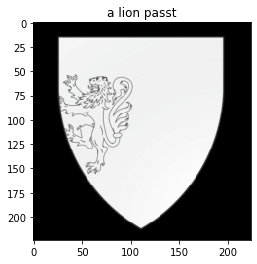

error in accessing key of predicted_cap 1


Epoch 3:  67%|████████████████████████████████▋                | 4/6 [00:12<00:05,  2.74s/batch, loss=1.28]

correct_caption:  a v lion rampant
predicted_caption:  a lion passt


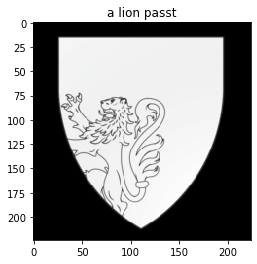

error in accessing key of predicted_cap 1
correct_caption:  b g lion passt
predicted_caption:  a a lion passt


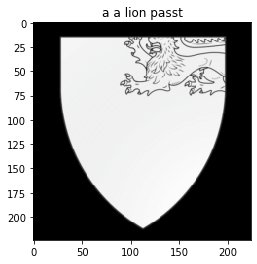

Epoch 3:  83%|████████████████████████████████████████▊        | 5/6 [00:14<00:02,  2.52s/batch, loss=1.15]

correct_caption:  b g lion passt
predicted_caption:  a a lion passt


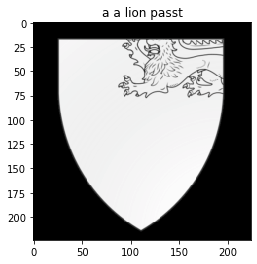

correct_caption:  a g lion passt guard
predicted_caption:  a lion passt


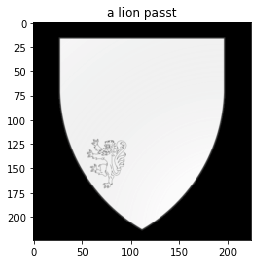

error in accessing key of predicted_cap 1


Epoch 4:   0%|                                                         | 0/6 [00:01<?, ?batch/s, loss=1.13]

correct_caption:  a o lion passt guard
predicted_caption:  a lion passt


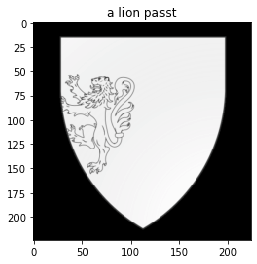

error in accessing key of predicted_cap 1
correct_caption:  b g lion passt
predicted_caption:  a lion passt


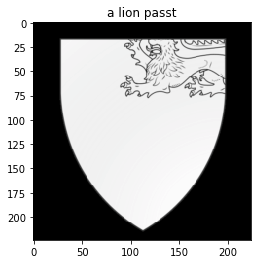

Epoch 4:  17%|████████▎                                         | 1/6 [00:05<00:26,  5.34s/batch, loss=1.1]

error in accessing key of predicted_cap 1
correct_caption:  b v lion 's head
predicted_caption:  a a lion passt


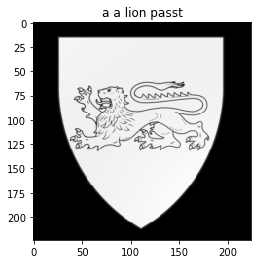

correct_caption:  a o lion passt guard
predicted_caption:  a lion passt


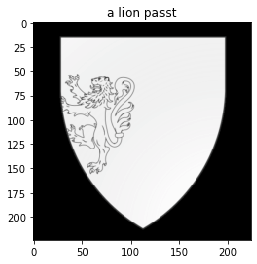

error in accessing key of predicted_cap 1


Epoch 4:  33%|████████████████▎                                | 2/6 [00:07<00:14,  3.71s/batch, loss=1.04]

correct_caption:  a g lion 's head
predicted_caption:  a lion passt


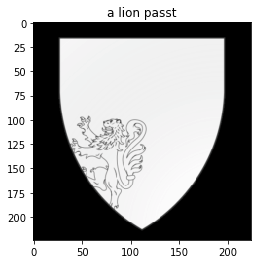

error in accessing key of predicted_cap 1
correct_caption:  b v lion 's head
predicted_caption:  a lion passt


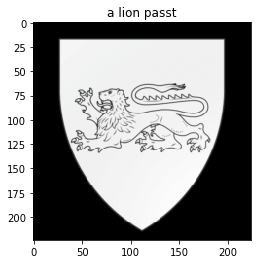

error in accessing key of predicted_cap 1


Epoch 4:  50%|█████████████████████████                         | 3/6 [00:10<00:08,  2.98s/batch, loss=1.3]

correct_caption:  a o lion passt guard
predicted_caption:  a lion passt


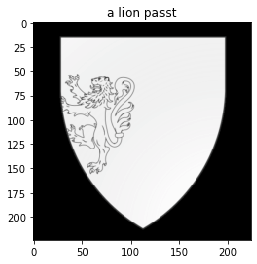

error in accessing key of predicted_cap 1
correct_caption:  b s lion rampant
predicted_caption:  a lion passt


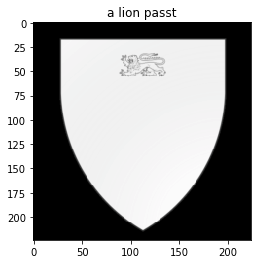

error in accessing key of predicted_cap 1


Epoch 4:  67%|████████████████████████████████▋                | 4/6 [00:12<00:05,  2.64s/batch, loss=1.07]

correct_caption:  a o lion 's head
predicted_caption:  a lion passt


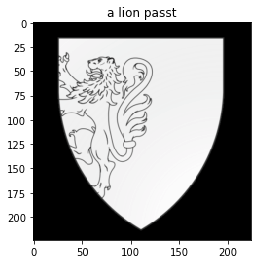

error in accessing key of predicted_cap 1
correct_caption:  b g lion passt
predicted_caption:  a lion passt


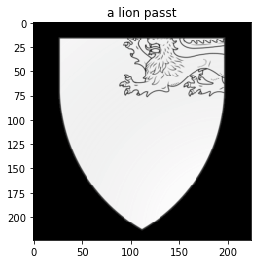

error in accessing key of predicted_cap 1


Epoch 4:  83%|████████████████████████████████████████        | 5/6 [00:14<00:02,  2.46s/batch, loss=0.998]

correct_caption:  a g lion passt guard
predicted_caption:  b lion passt


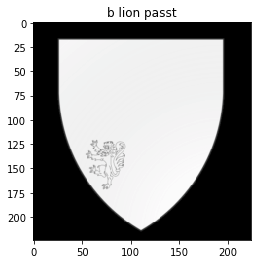

error in accessing key of predicted_cap 1
correct_caption:  a g lion 's head
predicted_caption:  b b lion passt


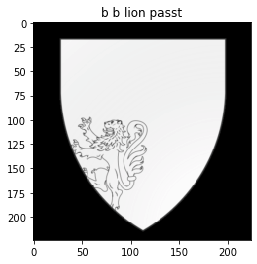

Epoch 5:   0%|                                                         | 0/6 [00:01<?, ?batch/s, loss=1.05]

correct_caption:  a v lion passt guard
predicted_caption:  b lion passt


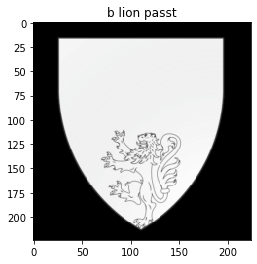

error in accessing key of predicted_cap 1
correct_caption:  a o lion rampant
predicted_caption:  b b lion passt


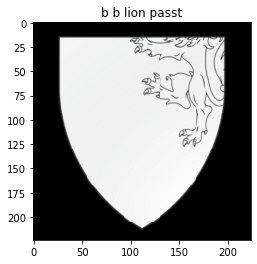

Epoch 5:  17%|████████▏                                        | 1/6 [00:05<00:29,  5.91s/batch, loss=1.17]

correct_caption:  a g lion passt guard
predicted_caption:  b b lion passt


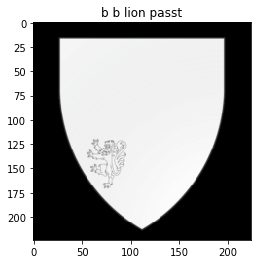

correct_caption:  a g lion 's head
predicted_caption:  b b lion passt


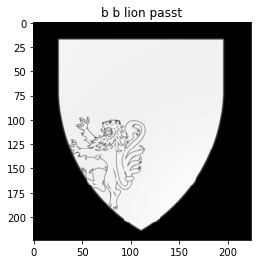

Epoch 5:  33%|████████████████▎                                | 2/6 [00:08<00:15,  3.95s/batch, loss=1.03]

correct_caption:  a o lion 's head
predicted_caption:  b b lion passt


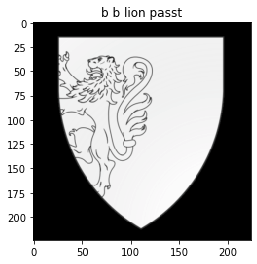

correct_caption:  a o lion passt guard
predicted_caption:  b b lion passt


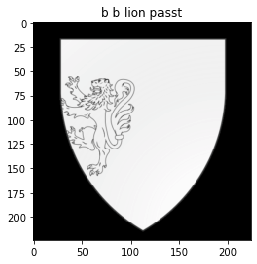

Epoch 5:  50%|████████████████████████                        | 3/6 [00:10<00:09,  3.12s/batch, loss=0.965]

correct_caption:  b g lion passt
predicted_caption:  b b lion passt


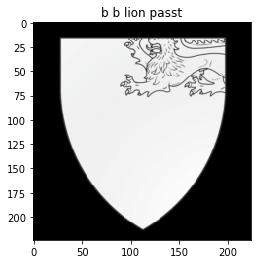

correct_caption:  a g lion 's head
predicted_caption:  b b lion passt


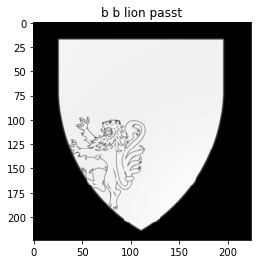

Epoch 5:  67%|████████████████████████████████                | 4/6 [00:12<00:05,  2.74s/batch, loss=0.933]

correct_caption:  a v lion passt guard
predicted_caption:  b b lion passt


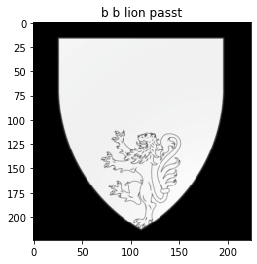

correct_caption:  b s lion rampant
predicted_caption:  b b lion passt


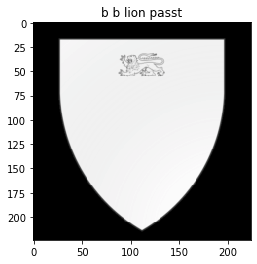

Epoch 5:  83%|████████████████████████████████████████        | 5/6 [00:14<00:02,  2.52s/batch, loss=0.893]

correct_caption:  a o lion rampant
predicted_caption:  b a lion passt


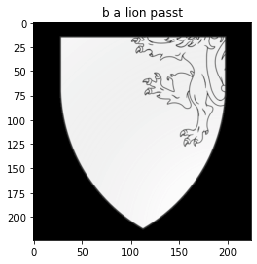

correct_caption:  a v lion rampant
predicted_caption:  b b lion passt


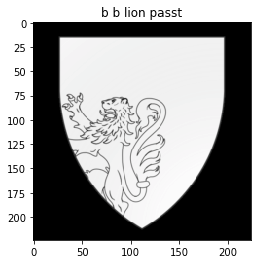

Epoch 5: 100%|████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.85s/batch, loss=0.893]

2.2254390490747407e-158
Final accuracy:  6000.0


In [56]:
losses = list()

model_full_path = '/home/space/datasets/COA/models/baseline/attention_model_state-smalll-thu.pth'
num_epochs = 5
print_every = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# if model is None:

for epoch in range(1, num_epochs + 1): 
    if model is None:
        model, optimizer, epoch, loss = load_model_checkpoint(model_full_path)

    with tqdm(train_loader, unit="batch") as tepoch:
        idx = 0
        for image, captions in tepoch:
            idx+=1
            tepoch.set_description(f"Epoch {epoch}")
            image, captions = image.to(device), captions.to(device)

            # Zero the gradients.
            optimizer.zero_grad()
            # Feed forward
            outputs, attentions = model(image, captions.T)
            # Calculate the batch loss.
            targets = captions.T[:,1:]  ####### the fix in here
            
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            # Backward pass. 
            loss.backward()
            # Update the parameters in the optimizer.
            optimizer.step()
            
            tepoch.set_postfix(loss=loss.item())
            sleep(0.1)
 
            bleu_score, accuracy = validate(model)

            model.train()
            losses.append(loss)

            

print(bleu_score/8091)
print('Final accuracy: ', accuracy/100)

                
    #save the latest model
#     save_model(model, optimizer, epoch, model_full_path)

In [ ]:
# losses = list()
# for epoch in tqdm(range(5)):
#     epoch_losses = train_epoch(model, device, train_loader, optimizer)
#     print(f"Average loss in epoch {epoch}: {np.mean(epoch_losses):.5f}")
#     losses.extend(epoch_losses)

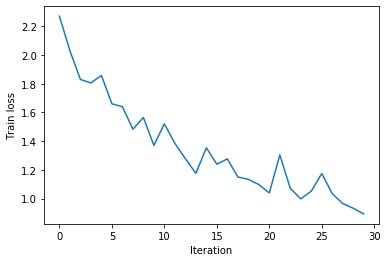

In [57]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.show()

In [ ]:
torch.cuda.empty_cache()


##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [49]:
#generate caption
def get_caps_from(model, features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
    
def test_rand_image(model):
    dataiter = iter(test_loader)
    images,_ = next(dataiter)

    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps,alphas = get_caps_from(model, img.unsqueeze(0))

    plot_attention(img1, caps, alphas)
    


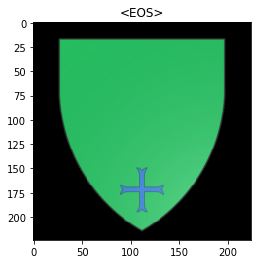

ValueError: num must be 1 <= num <= 0, not 1

<Figure size 1080x1080 with 0 Axes>

In [50]:
# torch.cuda.empty_cache()

model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
model = load_trained_model(model_path)
test_rand_image(model)